Sebagai perhatian, seluruh kode ini dijalankan menggunakan backend Python 3.10 dan Scikit Learn 1.3.0.

### Soal

Sebagai Data Scientist, anda diminta untuk membuat sebuah prediction model yang mampu memprediksi business metric y, menggunakan variabel dari metrics x.

Bagaimana cara anda membuat:
1. Predictive model yang akurat dan reliable terhadap bisnis tersebut ?
2. Tunjukkan pada manajemen, variable atau atribut mana saja yang mampu memberikan hasil terbaik pada model.
3. Jelaskan juga top 3 variable paling berpengaruh terhadap prediksi, dan apa efeknya pada metric bisnis y

Buatlah sebuah API sederhana sehingga model yang anda buat, dapat digunakan oleh perusahaan tersebut, dengan ketentuan sebagai berikut:
- Buat API dengan menggunakan python
- Request dan response menggunakan Json Payload
- Port yang digunakan adalah port 80

#### Jawab
---

Hal yang pertama dilakukan adalah inisiasi data.

In [6]:
import logging
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats as stats
from scipy.stats import zscore
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")
logging.basicConfig(filename='dump.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger().addHandler(logging.StreamHandler())

In [7]:
df = pd.read_csv('data/Data Science Case Studies.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)  # Terdapat dump index yang tidak perlu
df

,y,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,x11,x12,x13,x14,x15,x16
0,NaN,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20
1,475.0,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,480.0,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,500.0,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,91.5,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,700.0,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3
318,875.0,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20
319,385.0,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7
320,960.0,573,144,9,85,60,78,8,3198,857,97,470,420,332,1314,131,12


#### Predictive model yang akurat dan reliable

##### Eksplorasi Data

Sebagai awal, saya akan melihat distribusi data dari masing-masing kolom.

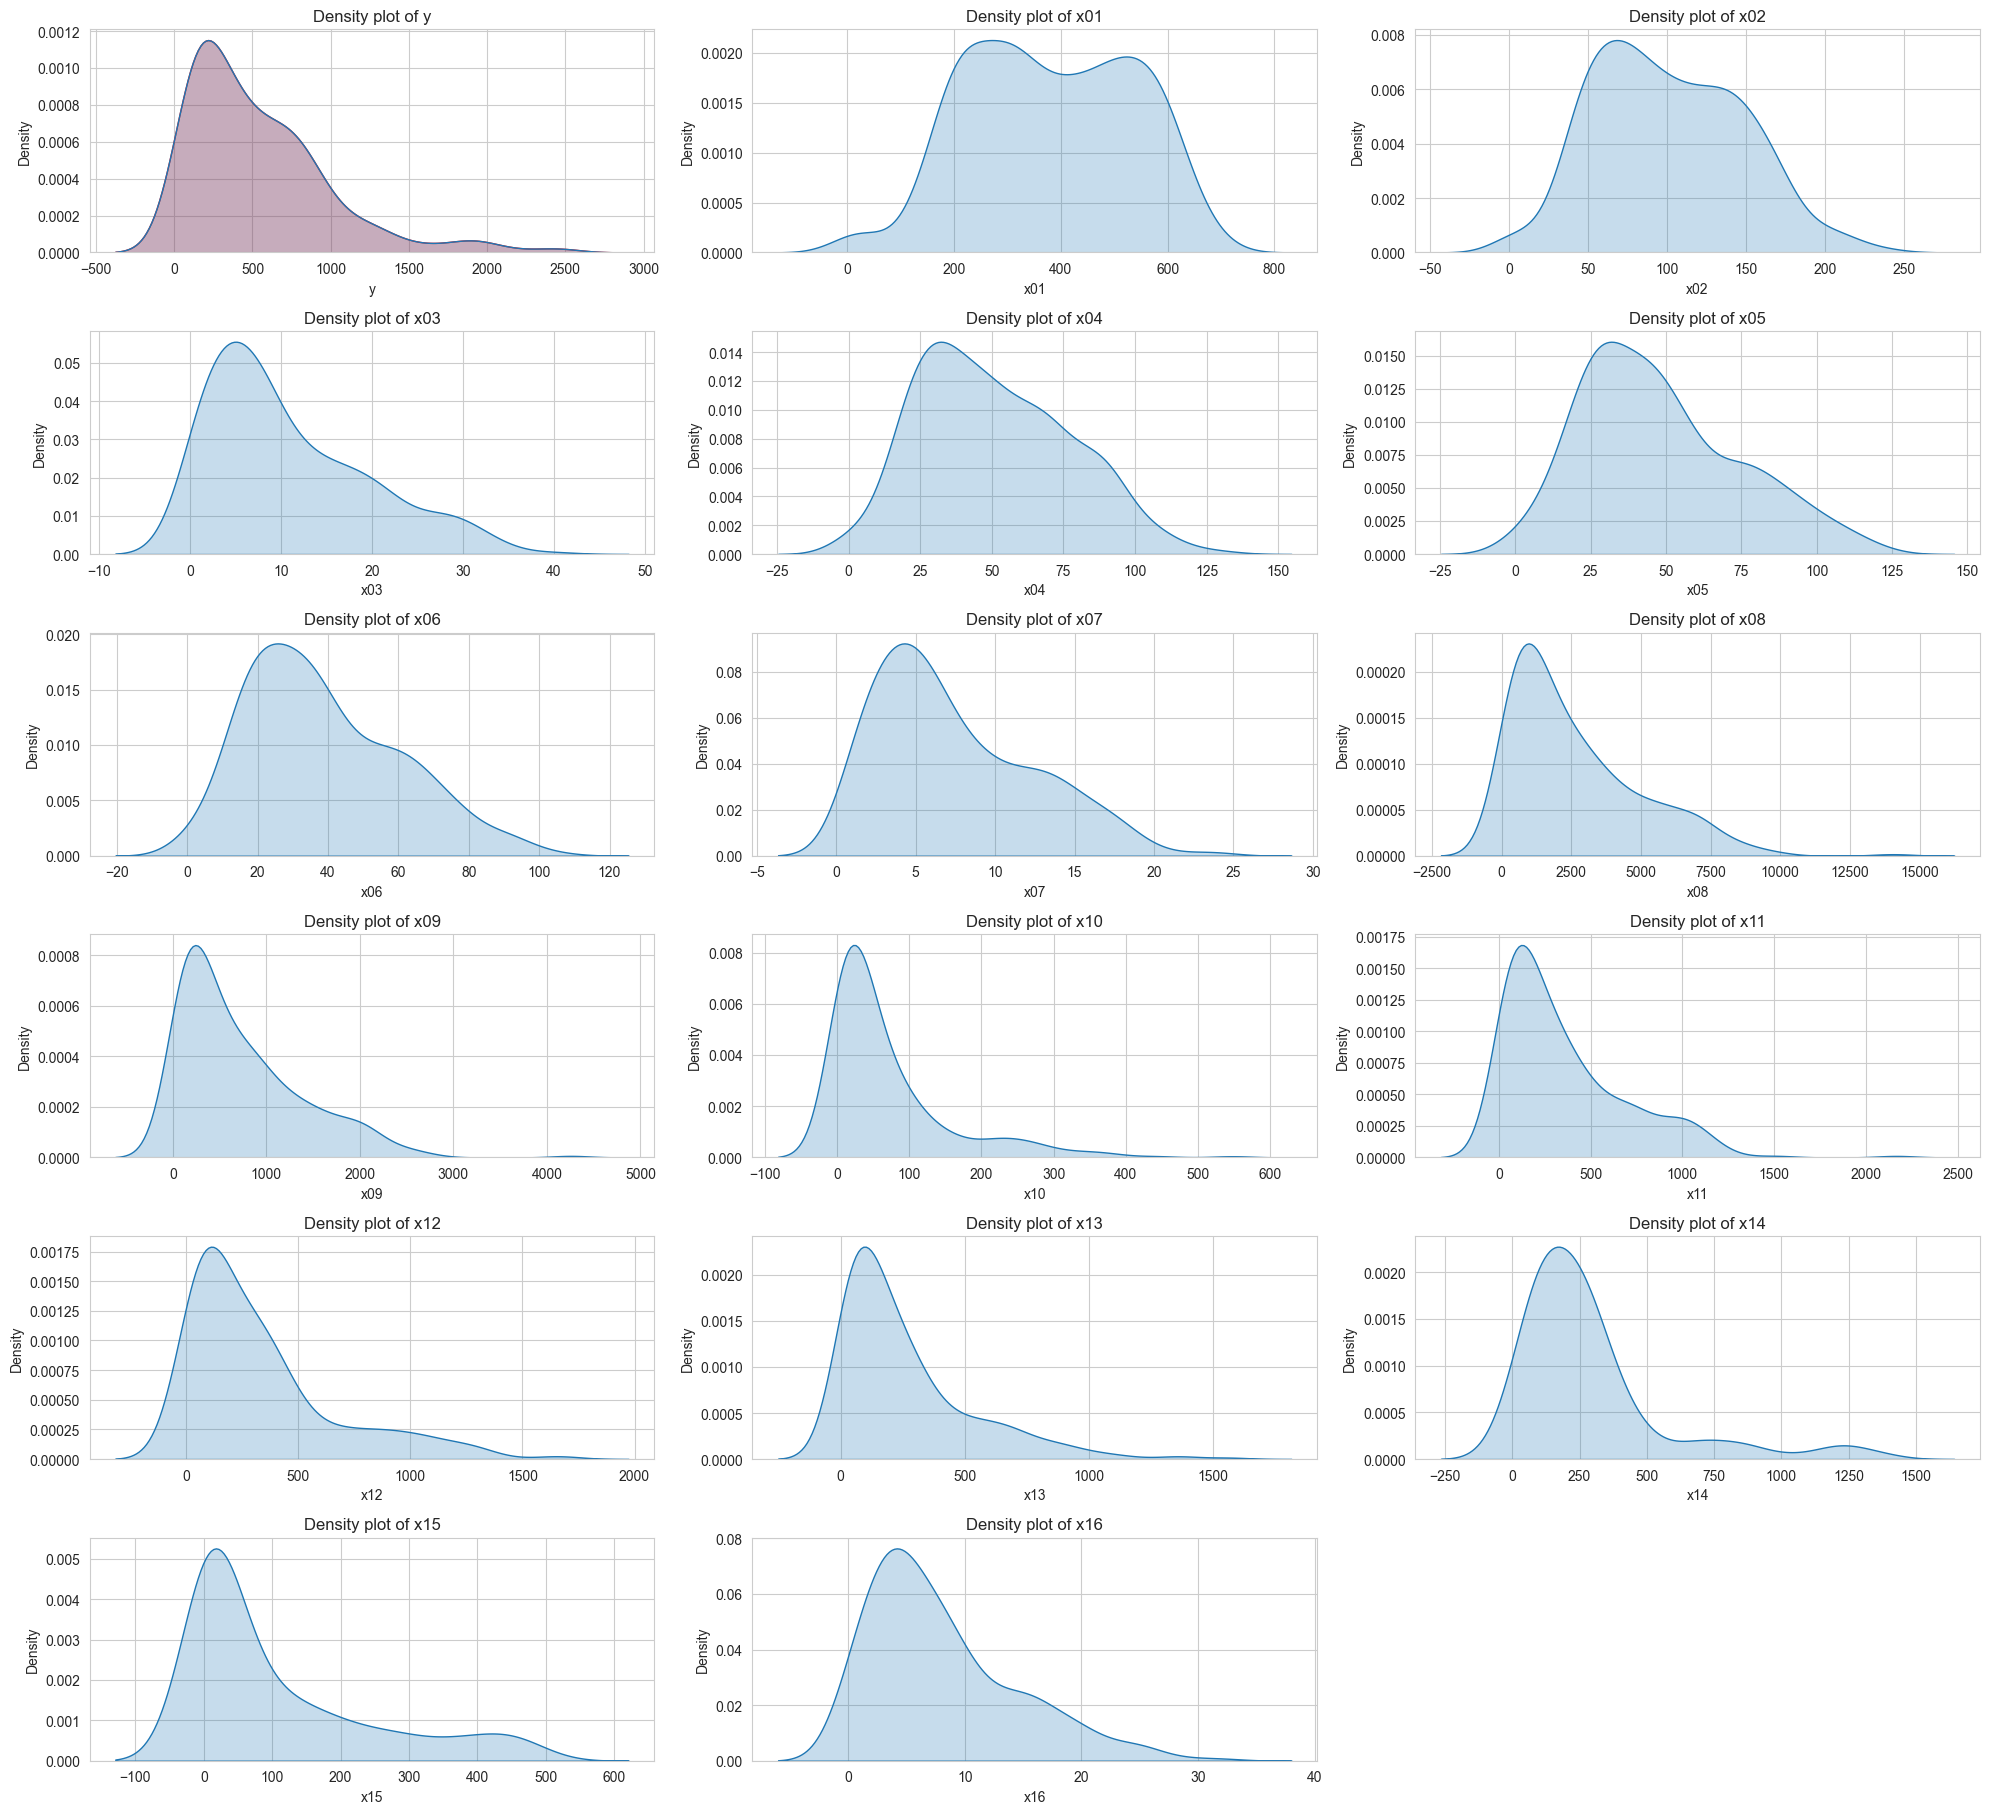

In [8]:
num_cols = df.shape[1]
warnings.filterwarnings('ignore', 'The figure layout has changed to tight')

plt.figure(figsize=(20, 3 * num_cols))
for i, feature in enumerate(df.columns, 1):
    plt.subplot(num_cols, 3, i)
    if feature == 'y':
        sns.kdeplot(df[feature], fill=True, color='red')
    sns.kdeplot(df[feature], fill=True)
    plt.title(f"Density plot of {feature}")
    plt.tight_layout()

plt.show()

Jika dilihat dari distribusi data, mayoritas (termasuk variabel target) memiliki distribusi yang tidak normal dan right-skewed.

Selanjutnya, saya akan melihat outlier dari masing-masing kolom menggunakan boxplot.

In [9]:
def generate_boxplot(df):
    """
    Fungsi untuk membuat boxplot dari setiap kolom pada dataframe.

    Args:
        df: dataframe yang akan dibuat boxplot
    """
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df)
    plt.title("Boxplots for All Columns")
    plt.show()

    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df)
    plt.title("Boxplots for All Columns (limit to 1000)")
    plt.ylim(0, 1000)
    plt.show()

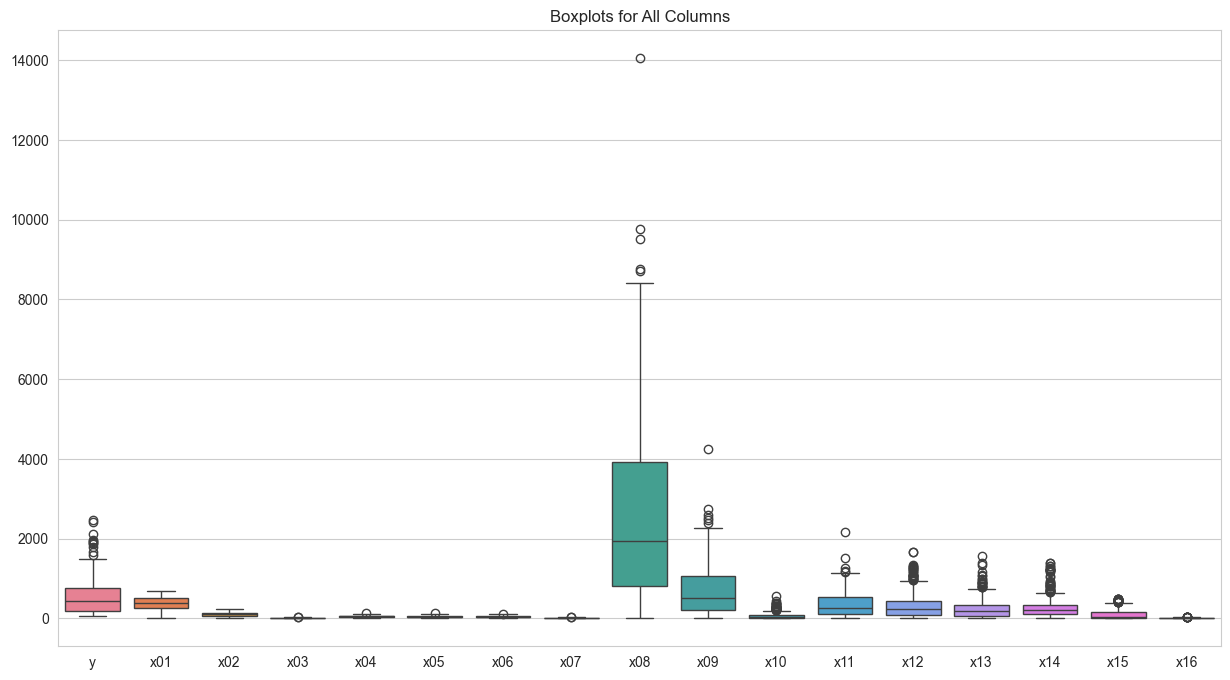

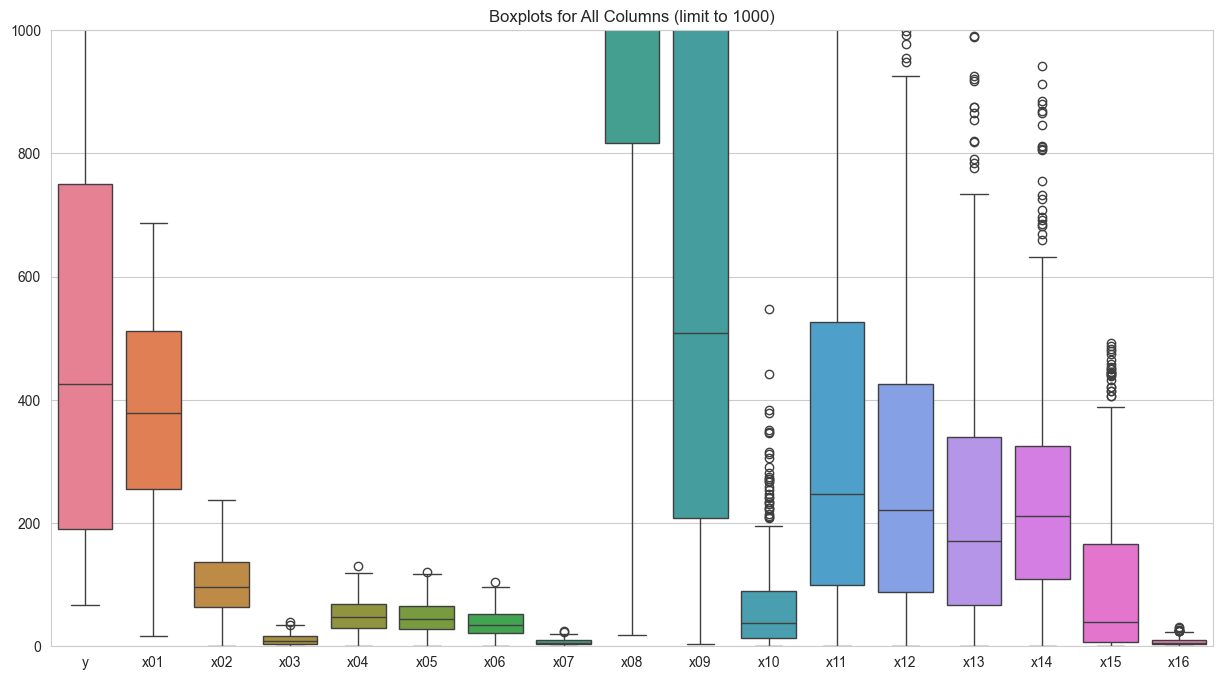

In [10]:
generate_boxplot(df)

Dari boxplot terlihat bahwa kolom `x08` memiliki rentang data yang sangat luas dibandingkan kolom lainnya.

Beberapa kolom juga memiliki outlier yang cukup banyak sehingga perlu dilakukan penanganan outlier.

Setelah itu, saya akan memeriksa korelasi antar variabel.

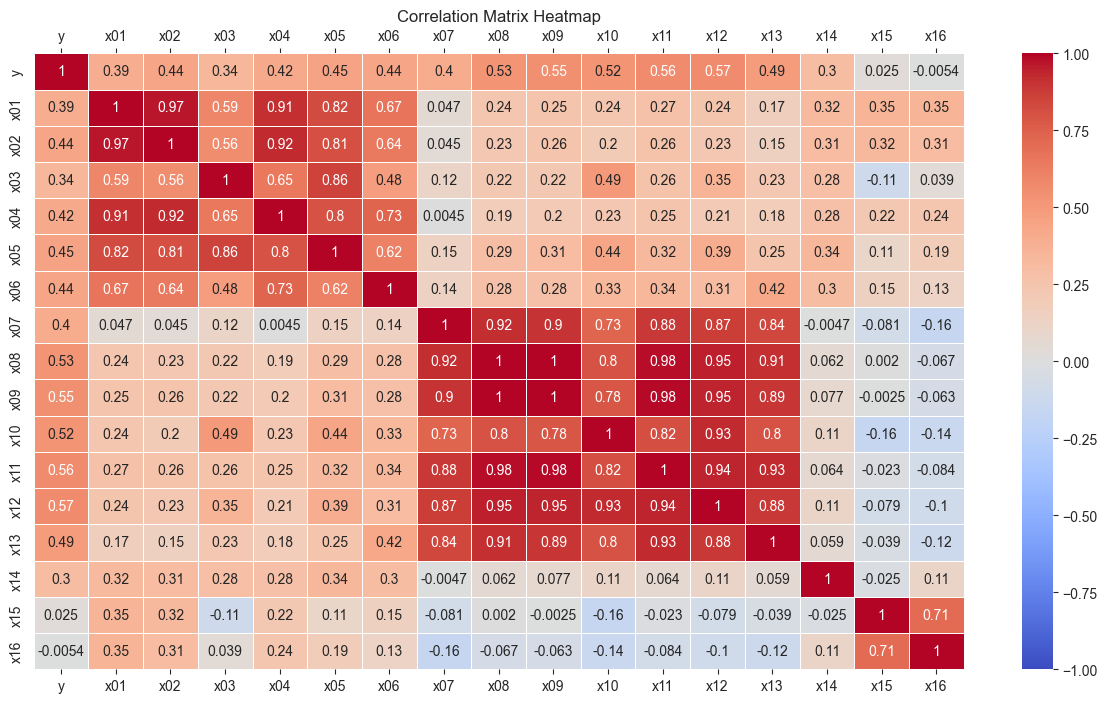

In [11]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True, labeltop=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

Dari sini terlihat bahwa kolom `x08` sampai `x13` memiliki korelasi positif yang cukup tinggi satu sama lain, begitu juga dengan kolom `y`.

##### Praproses

Menghapus outlier berdasarkan z-score dengan threshold 3 agar pengecekan lebih ketat.

In [12]:
z_scores = zscore(df.loc[:, 'x01':'x16'])
outliers_zscore = (z_scores > 3) | (z_scores < -3)

# Menghitung jumlah outliers
outliers_zscore_count = dict(outliers_zscore.sum())
outliers_zscore_count

{'x01': 0,
 'x02': 0,
 'x03': 1,
 'x04': 1,
 'x05': 0,
 'x06': 1,
 'x07': 2,
 'x08': 2,
 'x09': 2,
 'x10': 7,
 'x11': 2,
 'x12': 3,
 'x13': 5,
 'x14': 13,
 'x15': 0,
 'x16': 2}

In [13]:
# Menghapus baris yang mengandung outliers
rows_with_outliers = outliers_zscore.any(axis=1)
print(f"Baris dengan outliers: {rows_with_outliers.sum()}")
df = df[~rows_with_outliers]

Baris dengan outliers: 29


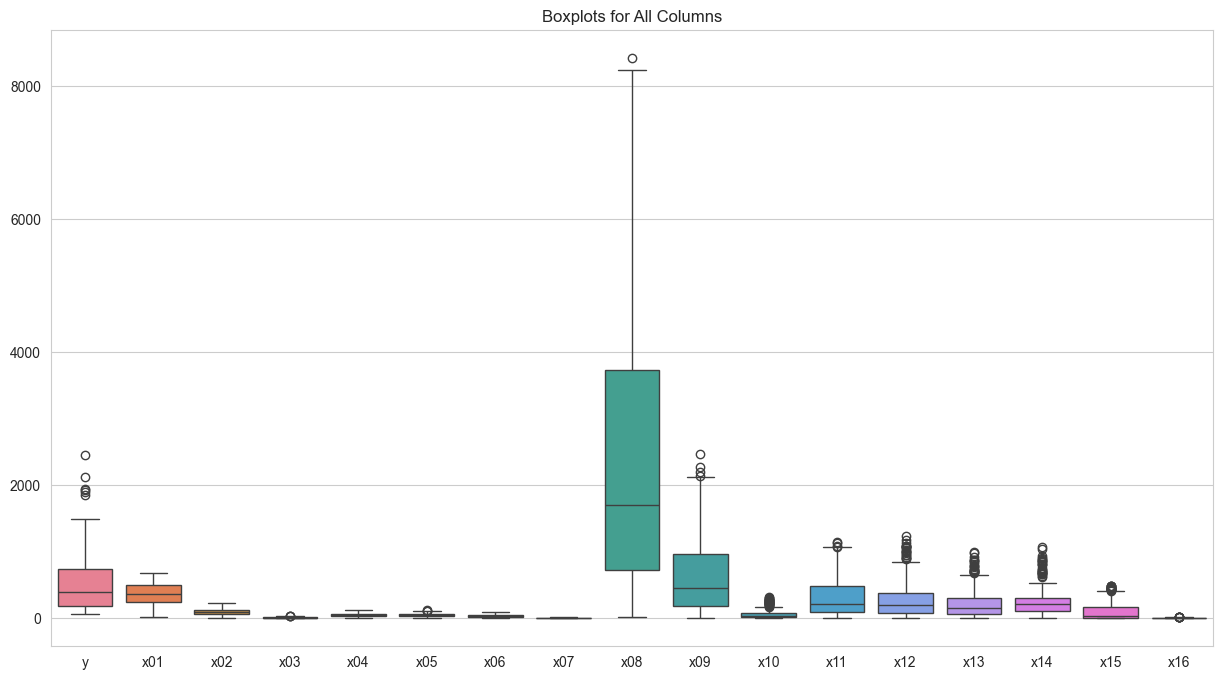

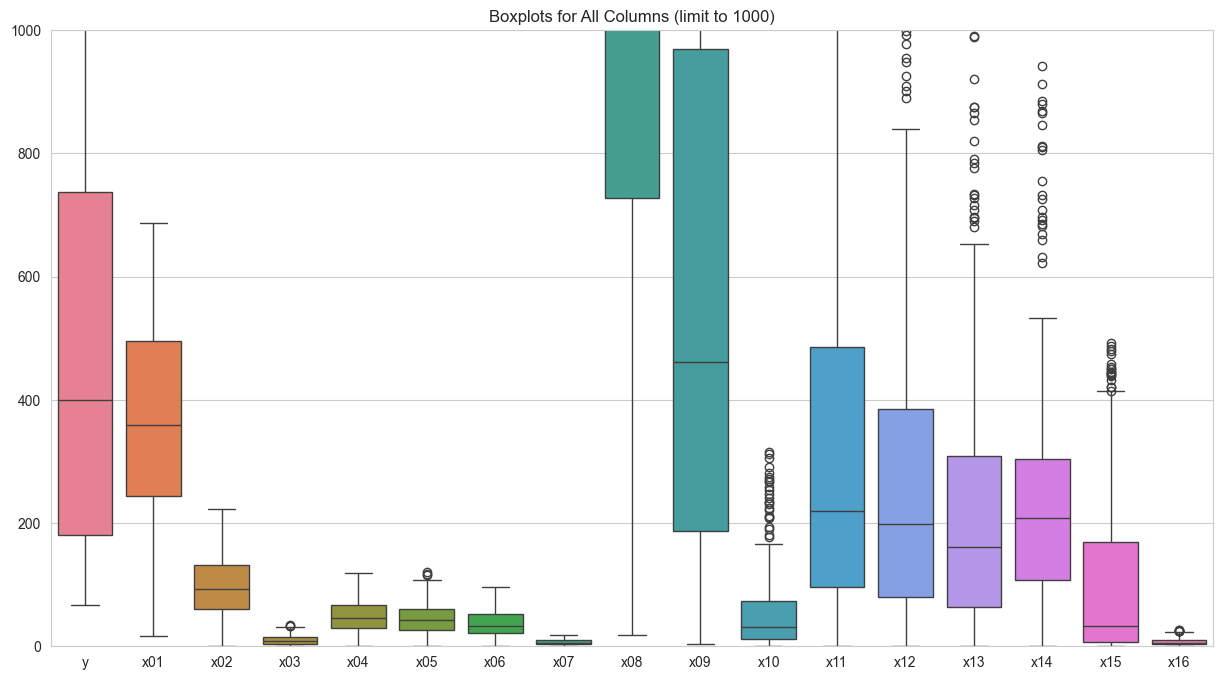

In [14]:
generate_boxplot(df)

Walau tak sepenuhnya hilang karena faktor distribusi data, outlier yang sangat jauh sudah tidak terlihat lagi.

Mengatasi data yang hilang

In [15]:
df.isnull().sum()

y      52
x01     0
x02     0
x03     0
x04     0
x05     0
x06     0
x07     0
x08     0
x09     0
x10     0
x11     0
x12     0
x13     0
x14     0
x15     0
x16     0
dtype: int64

Diketahui data hilang hanya muncul pada kolom `y`.

Oleh karena itu, saya memutuskan untuk menghilangkan baris dengan data yang hilang karena kolom `y` merupakan target dari model yang akan dibuat. Jika saya mengisinya dengan data mean/median, maka akan berisiko mempengaruhi hasil prediksi model karena data diisi dengan nilai artifisial yang mungkin tidak sesuai dengan relasinya terhadap kolom-kolom `x`.

Agar tidak terbuang sia-sia, saya akan memindahkan data yang hilang ke tabel terpisah alih-alih menghapusnya dengan tujuan untuk digunakan sebagai prediksi dari model yang akan dibuat.

In [16]:
# Hitung median dari kolom y
y_median = df['y'].median()
y_median

400.0

In [17]:
# Memindahkan tabel tanpa variabel y ke tabel baru
df_nan = df[df.isnull().any(axis=1)]
df_nan

# Menghapus baris yang tak memiliki nikai y
df = df[df['y'].notnull()]

In [18]:
df_nan.head()

,y,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,x11,x12,x13,x14,x15,x16
0,NaN,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20
15,NaN,183,39,3,20,15,11,3,201,42,3,20,16,11,118,0,0
18,NaN,407,104,6,57,43,65,12,5233,1478,100,643,658,653,912,88,9
22,NaN,22,10,1,4,2,1,6,84,26,2,9,9,3,812,84,11
36,NaN,161,36,0,19,10,17,4,1053,244,3,156,86,107,70,149,12


In [19]:
df_nan.to_json('df_nan.json', orient='records')

In [20]:
df

,y,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,x11,x12,x13,x14,x15,x16
1,475.0,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,480.0,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,500.0,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,91.5,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4
5,750.0,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,120.0,408,117,11,66,41,34,1,408,117,11,66,41,34,942,72,11
317,700.0,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3
318,875.0,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20
319,385.0,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7


##### Pembuatan model

In [21]:
def split_data(df, print_info=True):
    """
    Fungsi untuk memecah data menjadi train, validate, dan test.

    Args:
        df: Data yang akan dipisah.
    Returns:
        X_train: Data input untuk train.
        y_train: Data output untuk train.
        X_validate: Data input untuk validate.
        y_validate: Data output untuk validate.
        X_test: Data input untuk test.
        y_test: Data output untuk test.
    """
    logging.info("Membuat model...")
    logging.info(f"Jumlah data: {df.shape[0]}")

    # Pembagian data menjadi 70% train, 15% validate, 15% test
    train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)
    validate_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)
    logging.info(f"Jumlah data train: {train_data.shape[0]}")
    logging.info(f"Jumlah data validate: {validate_data.shape[0]}")
    logging.info(f"Jumlah data test: {test_data.shape[0]}\n")

    # Pemisahan data input dan output
    X_train = train_data.drop(columns=['y'])
    y_train = train_data['y']

    X_validate = validate_data.drop(columns=['y'])
    y_validate = validate_data['y']

    X_test = test_data.drop(columns=['y'])
    y_test = test_data['y']

    return X_train, y_train, X_validate, y_validate, X_test, y_test

def model_training(X_train, y_train, X_validate, y_validate, X_test, y_test):
    """
    Fungsi untuk melatih model.

    Args:
        X_train: Data input untuk train.
        y_train: Data output untuk train.
        X_validate: Data input untuk validate.
        y_validate: Data output untuk validate.
        X_test: Data input untuk test.
        y_test: Data output untuk test.
    Returns:
        rf_model: Model yang telah dilatih.
        y_validate_pred: Prediksi output pada data validate.
        y_test_pred: Prediksi output pada data test.
        mse_validate: MSE pada data validate.
        mse_test: MSE pada data test.
    """
    logging.info("Melatih model...")

    # Menetapkan parameter dan melatih model
    param_grid = {
        'n_estimators': [10, 50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [1.0, 'sqrt']
    }
    rf_model = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rf_model.fit(X_train, y_train)

    best_params = rf_model.best_params_
    logging.info("Parameter terbaik:")
    for param_name in best_params:
        logging.info(f"{param_name}: {best_params[param_name]}")

    # Menghitung MSE dan R2 score pada data train, validate, dan test
    y_validate_pred = rf_model.predict(X_validate)
    mse_validate = mean_squared_error(y_validate, y_validate_pred)
    r2_validate = r2_score(y_validate, y_validate_pred)
    logging.info(f"MSE pada data validate: {mse_validate}")
    logging.info(f"R2 score pada data validate: {r2_validate}")

    y_test_pred = rf_model.predict(X_test) 
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    logging.info(f"MSE pada data test: {mse_test}")
    logging.info(f"R2 score pada data test: {r2_test}\n")

    return rf_model, y_validate_pred, y_test_pred, mse_validate, mse_test, r2_validate, r2_test

In [22]:
def generate_plot(y_validate, y_validate_pred, additional_text):
    """
    Fungsi untuk menghasilkan plot residual dan normal Q-Q plot.

    Args:
        y_validate: Data output pada data validate.
        y_validate_pred: Prediksi output pada data validate.
        additional_text: Teks tambahan untuk judul plot.
    """
    residual = y_validate - y_validate_pred

    plt.figure(figsize=(15, 4))
    plt.scatter(y_validate_pred, residual, color="blue", alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="-")
    plt.title(f"Residual plot{additional_text}")
    plt.ylabel("Residual")
    plt.xlabel("Predicted value")
    plt.show()

    stats.probplot(residual, dist="norm", plot=pylab)
    plt.scatter([], [], c='blue', alpha=0.5)
    plt.title(f"Normal Q-Q plot{additional_text}")
    plt.show()


##### Iterasi 1

In [23]:
logging.info("Initial Condition")
X_train, y_train, X_validate, y_validate, X_test, y_test = split_data(df)
rf_model, y_validate_pred, y_test_pred, mse_validate, mse_test, r2_validate, r2_test = model_training(X_train, y_train, X_validate, y_validate, X_test, y_test)

Initial Condition
Membuat model...
Jumlah data: 241
Jumlah data train: 168
Jumlah data validate: 36
Jumlah data test: 37

Melatih model...
Parameter terbaik:
max_depth: None
max_features: 1.0
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 50
MSE pada data validate: 25321.901457725493
R2 score pada data validate: 0.7662954019494987
MSE pada data test: 81769.72648434438
R2 score pada data test: 0.6280326243674739



Dilihat dari hasil yang didapatkan, MSE dan R2 masih belum memuaskan, terutama pada data test.

Untuk memastikan, saya juga melihat plot residual dan QQ plot.

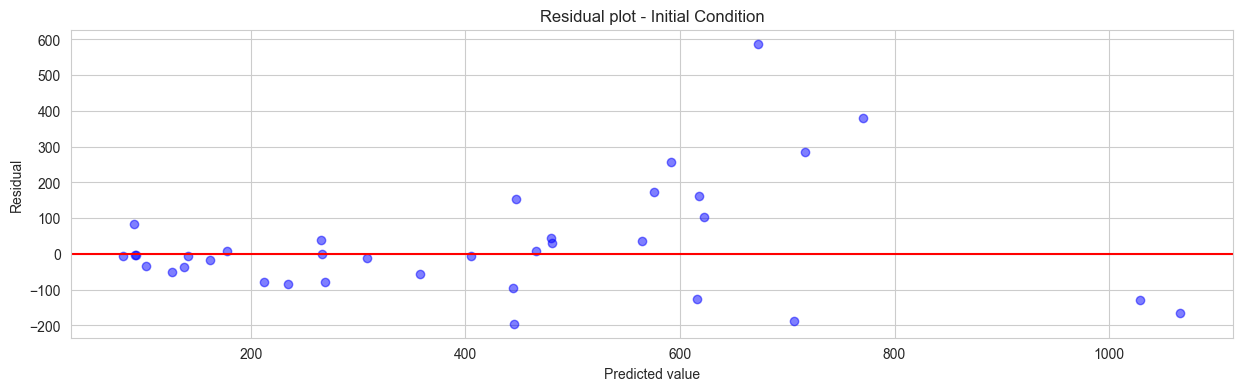

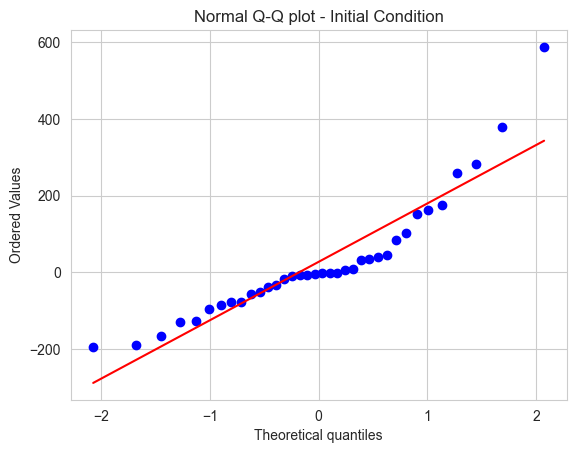

In [24]:
generate_plot(y_validate, y_validate_pred, " - Initial Condition")

Dari plot residual, terlihat bahwa data lebih akurat pada nilai-nilai yang kecil, namun semakin besar nilai prediksi, semakin besar pula error yang dihasilkan.

Hal ini juga terlihat pada QQ plot, dimana data tidak mengikuti garis diagonal, terutama di bagian atas.

Oleh karena itu, saya memutuskan untuk melakukan transformasi logaritmik pada kolom `y` agar distribusi datanya menjadi lebih baik.

##### Iterasi 2

In [25]:
df_log = df.copy()
df_log['y'] = np.log(df_log['y'] + 1)

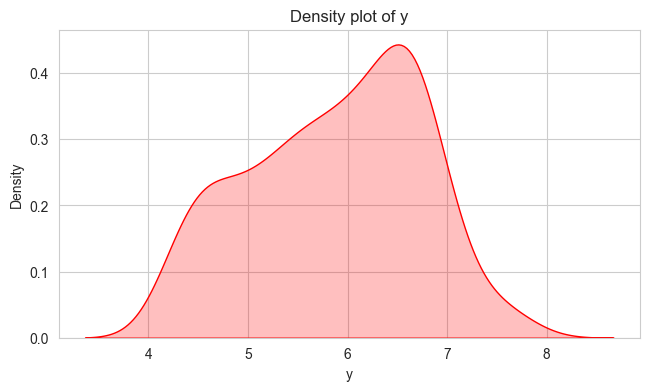

In [26]:
# Buat kde plot untuk melihat distribusi data y setelah transformasi
plt.figure(figsize=(7.5, 4))
sns.kdeplot(df_log['y'], fill=True, color='red')
plt.title("Density plot of y")
plt.show()

In [27]:
logging.info("Log Transformation")
X_train, y_train, X_validate, y_validate, X_test, y_test = split_data(df_log)
rf_model, y_validate_pred, y_test_pred, mse_validate, mse_test, r2_validate, r2_test = model_training(X_train, y_train, X_validate, y_validate, X_test, y_test)

Log Transformation
Membuat model...
Jumlah data: 241
Jumlah data train: 168
Jumlah data validate: 36
Jumlah data test: 37

Melatih model...
Parameter terbaik:
max_depth: None
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 5
n_estimators: 100
MSE pada data validate: 0.08586498784503827
R2 score pada data validate: 0.8836312496385225
MSE pada data test: 0.12572729602918292
R2 score pada data test: 0.8327504944425401



Dengan melakukan transformasi logaritmik, nilai MSE menurun dengan signifikan, dan nilai R2 terlihat cukup memuaskan.

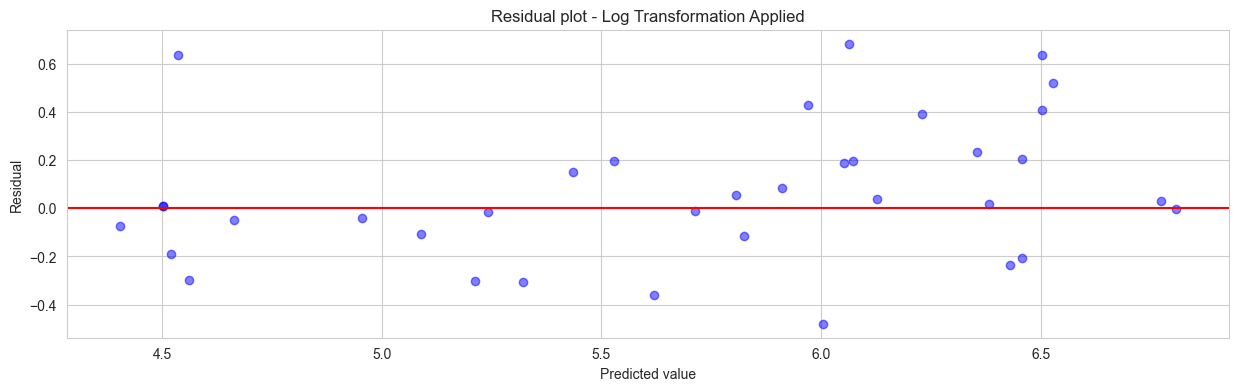

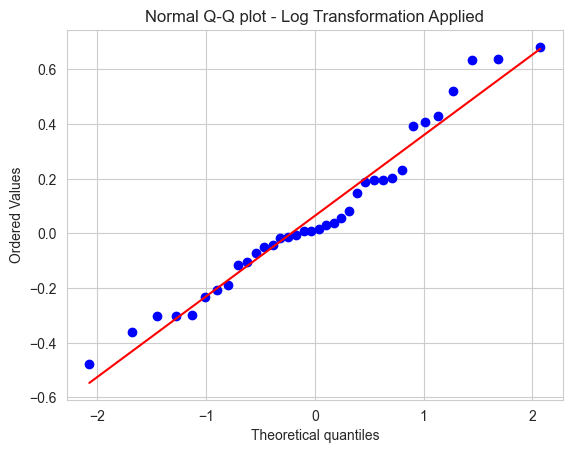

In [28]:
generate_plot(y_validate, y_validate_pred, " - Log Transformation Applied")

Dari plot residual, terlihat bahwa data lebih menyebar secara merata, walau masih terdapat beberapa data yang cukup jauh dari prediksi.

Dari plot QQ, terlihat bahwa data sudah mengikuti garis diagonal dengan cukup baik.

Dengan begini, model iterasi 2 lah yang akan digunakan untuk ke depannya.

##### Prediksi

In [29]:
X_predict = df_nan.drop(columns=['y'])
y_predict = rf_model.predict(X_predict)
y_predict = np.exp(y_predict) - 1  # Mengembalikan hasil prediksi ke bentuk semula
y_predict = np.round(y_predict * 2) / 2  # Pembulatan ke 0.5 terdekat

df_nan['y'] = y_predict


In [30]:
df_nan

,y,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,x11,x12,x13,x14,x15,x16
0,82.5,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20
15,83.5,183,39,3,20,15,11,3,201,42,3,20,16,11,118,0,0
18,614.0,407,104,6,57,43,65,12,5233,1478,100,643,658,653,912,88,9
22,820.0,22,10,1,4,2,1,6,84,26,2,9,9,3,812,84,11
36,230.5,161,36,0,19,10,17,4,1053,244,3,156,86,107,70,149,12
38,501.5,346,98,5,31,53,30,16,5913,1615,235,784,901,560,0,0,0
39,82.5,241,61,1,34,12,14,1,241,61,1,34,12,14,166,172,10
41,379.5,216,54,0,21,18,15,18,7318,1926,46,796,627,483,103,84,5
42,427.5,200,57,6,23,14,14,9,2516,684,46,371,230,195,69,1,1
44,430.5,194,40,7,19,29,30,11,4183,1069,64,486,493,608,325,22,2


#### Variable atau atribut mana saja yang mampu memberikan hasil terbaik pada model

Dalam konteks Random Forest, variabel yang mampu memberikan hasil terbaik dipilih berdasarkan pentingnya fitur tersebut (feature importance) terhadap prediksi.

Feature importance mengukur seberapa sering sebuah variabel/fitur digunakan dan seberapa besar kontribusinya dalam meningkatkan akurasi model.

In [31]:
def feature_importances(rf_model):
    """
    Fungsi untuk menampilkan feature importances dari model.

    Args:
        rf_model: Model Random Forest yang telah dilatih.
    Returns:
        features_df_sorted: DataFrame yang berisi feature importances yang telah diurutkan.
    """

    feature_importances = rf_model.best_estimator_.feature_importances_
    features_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    })
    features_df_sorted = features_df.sort_values(by='Importance', ascending=False)

    # Menampilkan feature importances dalam bentuk bar plot
    plt.figure(figsize=(12, 8))
    plt.barh(features_df_sorted['Feature'], features_df_sorted['Importance'], alpha=0.7)
    for index, value in enumerate(features_df_sorted['Importance']):
        plt.text(value, index, str(round(value, 3)))
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

    return features_df_sorted

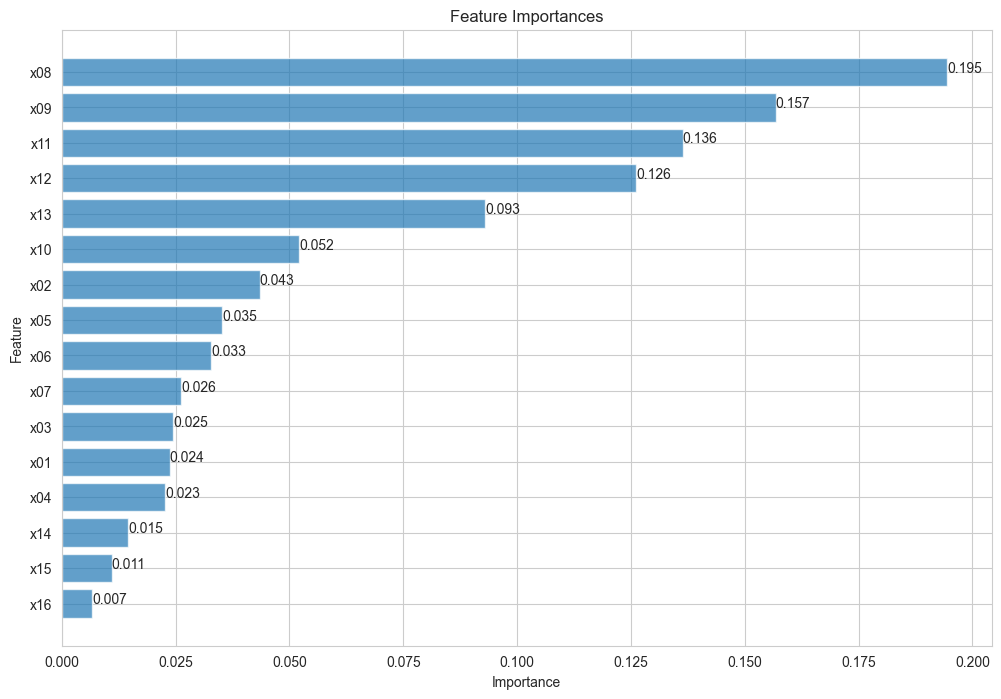

In [32]:
feature_importances = feature_importances(rf_model)

Berdasarkan grafik di atas, 5 variabel terbaik secara berurutan adalah:
1. x08
2. x09
3. x11
4. x12
5. x13

Kelima variabel ini memimpin dengan cukup jauh dibandingkan variabel lainnya. 

Ini artinya kelima variabel ini memiliki pengaruh yang signifikan dalam menentukan hasil prediksi model.

Untuk menguji, saya mencoba membuat iterasi pelatihan model dengan menggunakan susunan Feature Importance ini.

In [33]:
logging.getLogger().handlers.pop()
results = []

# Iterasi untuk mengevaluasi model dengan jumlah feature yang berbeda
for i in range(1, len(feature_importances)+1):
    top_features = feature_importances['Feature'].head(i).tolist()
    top_features.sort()
    X_train_selected = X_train[top_features]
    X_validate_selected = X_validate[top_features]
    X_test_selected = X_test[top_features]

    logging.info(f"Top {i} features: {top_features}")
    rf_model, y_validate_pred, y_test_pred, mse_validate, mse_test, r2_validate, r2_test = model_training(X_train_selected, y_train, X_validate_selected, y_validate, X_test_selected, y_test)

    results.append({
        'NumFeatures': i,
        'MSEValidate': mse_validate,
        'MSEValidateDiff': mse_validate - results[i-2]['MSEValidate'] if i > 1 else 0,
        'R2Validate': r2_validate,
        'R2ValidateDiff': r2_validate - results[i-2]['R2Validate'] if i > 1 else 0,
        'MSETest': mse_test,
        'MSETestDiff': mse_test - results[i-2]['MSETest'] if i > 1 else 0,
        'R2Test': r2_test,
        'R2TestDiff': r2_test - results[i-2]['R2Test'] if i > 1 else 0
    })

In [34]:
results_df = pd.DataFrame(results)

def highlight_max(col):
    """
    Fungsi untuk mewarnai sel yang berisi nilai maksimum.

    Args:
        col: Kolom pada DataFrame.
    Returns:
        List yang berisi warna untuk setiap sel.
    """

    if 'mse' in col.name.lower():
        is_min = col == col.min()
        return ['color: red' if v else '' for v in is_min]
    else:
        is_max = col == col.max()
        return ['color: red' if v else '' for v in is_max]


styled_df = results_df.style.apply(highlight_max)
styled_df

,NumFeatures,MSEValidate,MSEValidateDiff,R2Validate,R2ValidateDiff,MSETest,MSETestDiff,R2Test,R2TestDiff
0,1,0.112043,0.000000,0.848153,0.000000,0.253679,0.000000,0.662542,0.000000
1,2,0.096801,-0.015242,0.868810,0.020657,0.245927,-0.007752,0.672854,0.010312
2,3,0.100084,0.003283,0.864361,-0.004449,0.234496,-0.011431,0.688060,0.015206
3,4,0.135921,0.035837,0.815792,-0.048568,0.263344,0.028848,0.649685,-0.038375
4,5,0.112204,-0.023717,0.847935,0.032143,0.205990,-0.057354,0.725981,0.076295
5,6,0.146658,0.034454,0.801241,-0.046694,0.192724,-0.013266,0.743627,0.017647
6,7,0.104011,-0.042647,0.859039,0.057798,0.183266,-0.009458,0.756210,0.012582
7,8,0.084414,-0.019597,0.885597,0.026559,0.178608,-0.004658,0.762406,0.006196
8,9,0.067321,-0.017093,0.908763,0.023166,0.142307,-0.036301,0.810695,0.048289
9,10,0.078996,0.011675,0.892941,-0.015822,0.140199,-0.002109,0.813500,0.002805


Dari sini terlihat bahwa nilai R2 dan MSE mengalami peningkatan paling signifikan di 5 Fitur dan mencapai titik maksimal di 12 Fitur.

Dengan begitu, saya memutuskan untuk menggunakan 12 Fitur ini sebagai fitur yang akan digunakan pada model.

Adapun 4 Fitur yang akan ditinggalkan antara lain:
1. x04
2. x14
3. x15
4. x16

In [35]:
logging.getLogger().addHandler(logging.StreamHandler())
top_features = feature_importances['Feature'].head(12).tolist()
top_features.sort()
X_train_selected = X_train[top_features]
X_validate_selected = X_validate[top_features]
X_test_selected = X_test[top_features]

rf_model, y_validate_pred, y_test_pred, mse_validate, mse_test, r2_validate, r2_test = model_training(X_train_selected, y_train, X_validate_selected, y_validate, X_test_selected, y_test)

Melatih model...
Parameter terbaik:
max_depth: None
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 50
MSE pada data validate: 0.0838995536108384
R2 score pada data validate: 0.8862949095480105
MSE pada data test: 0.12364833599404658
R2 score pada data test: 0.835516043761835



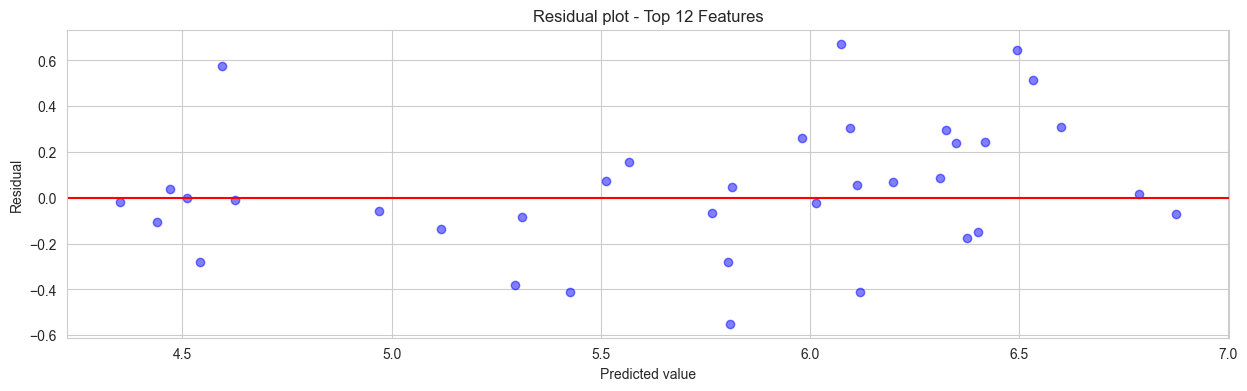

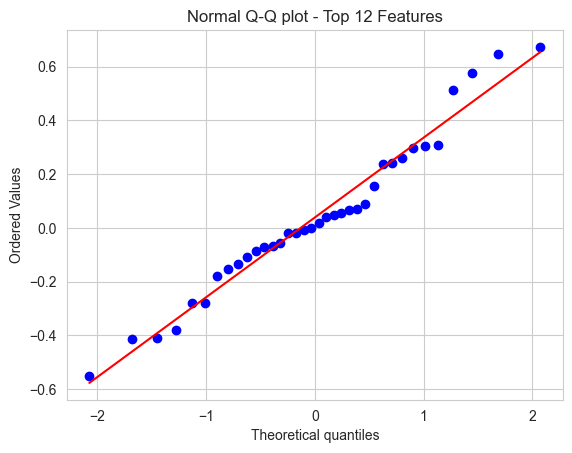

In [36]:
generate_plot(y_validate, y_validate_pred, " - Top 12 Features")

Jika dilihat dari residual dan QQ plot pun, model dengan Top 12 Features ini tampak sedikit lebih baik dibanding model dengan Seluruh Feature.

In [37]:
# predict df_nan with top 12 features
X_predict = df_nan[top_features]
y_predict = rf_model.predict(X_predict)
y_predict = np.exp(y_predict) - 1  # Mengembalikan hasil prediksi ke bentuk semula
y_predict = np.round(y_predict * 2) / 2  # Pembulatan ke 0.5 terdekat

# Pindahkan kolom y ke ujung kanan
cols = list(df_nan.columns)
cols.append(cols.pop(cols.index('y')))
df_nan = df_nan[cols]
df_nan['y_top12'] = y_predict


/var/folders/5q/__5twx5n1zjb0pvff6llq3qh0000gn/T/ipykernel_35704/2798512195.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan['y_top12'] = y_predict


In [38]:
df_nan

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,x11,x12,x13,x14,x15,x16,y,y_top12
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20,82.5,83.0
15,183,39,3,20,15,11,3,201,42,3,20,16,11,118,0,0,83.5,75.0
18,407,104,6,57,43,65,12,5233,1478,100,643,658,653,912,88,9,614.0,585.5
22,22,10,1,4,2,1,6,84,26,2,9,9,3,812,84,11,820.0,707.5
36,161,36,0,19,10,17,4,1053,244,3,156,86,107,70,149,12,230.5,227.0
38,346,98,5,31,53,30,16,5913,1615,235,784,901,560,0,0,0,501.5,536.5
39,241,61,1,34,12,14,1,241,61,1,34,12,14,166,172,10,82.5,76.0
41,216,54,0,21,18,15,18,7318,1926,46,796,627,483,103,84,5,379.5,345.0
42,200,57,6,23,14,14,9,2516,684,46,371,230,195,69,1,1,427.5,392.5
44,194,40,7,19,29,30,11,4183,1069,64,486,493,608,325,22,2,430.5,448.5


In [39]:
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

#### Top 3 variable paling berpengaruh terhadap prediksi, dan apa efeknya pada metric bisnis y

Berdasarkan pengujian sebelumnya, 3 variabel terbaik secara berurutan adalah:
1. x08
2. x09
3. x11

Untuk melihat efeknya pada metric bisnis `y`, saya akan melihat korelasi antara variabel-variabel ini dengan `y`.

##### Cara Pertama

Cara pertama adalah dengan visualisasi scatter plot.

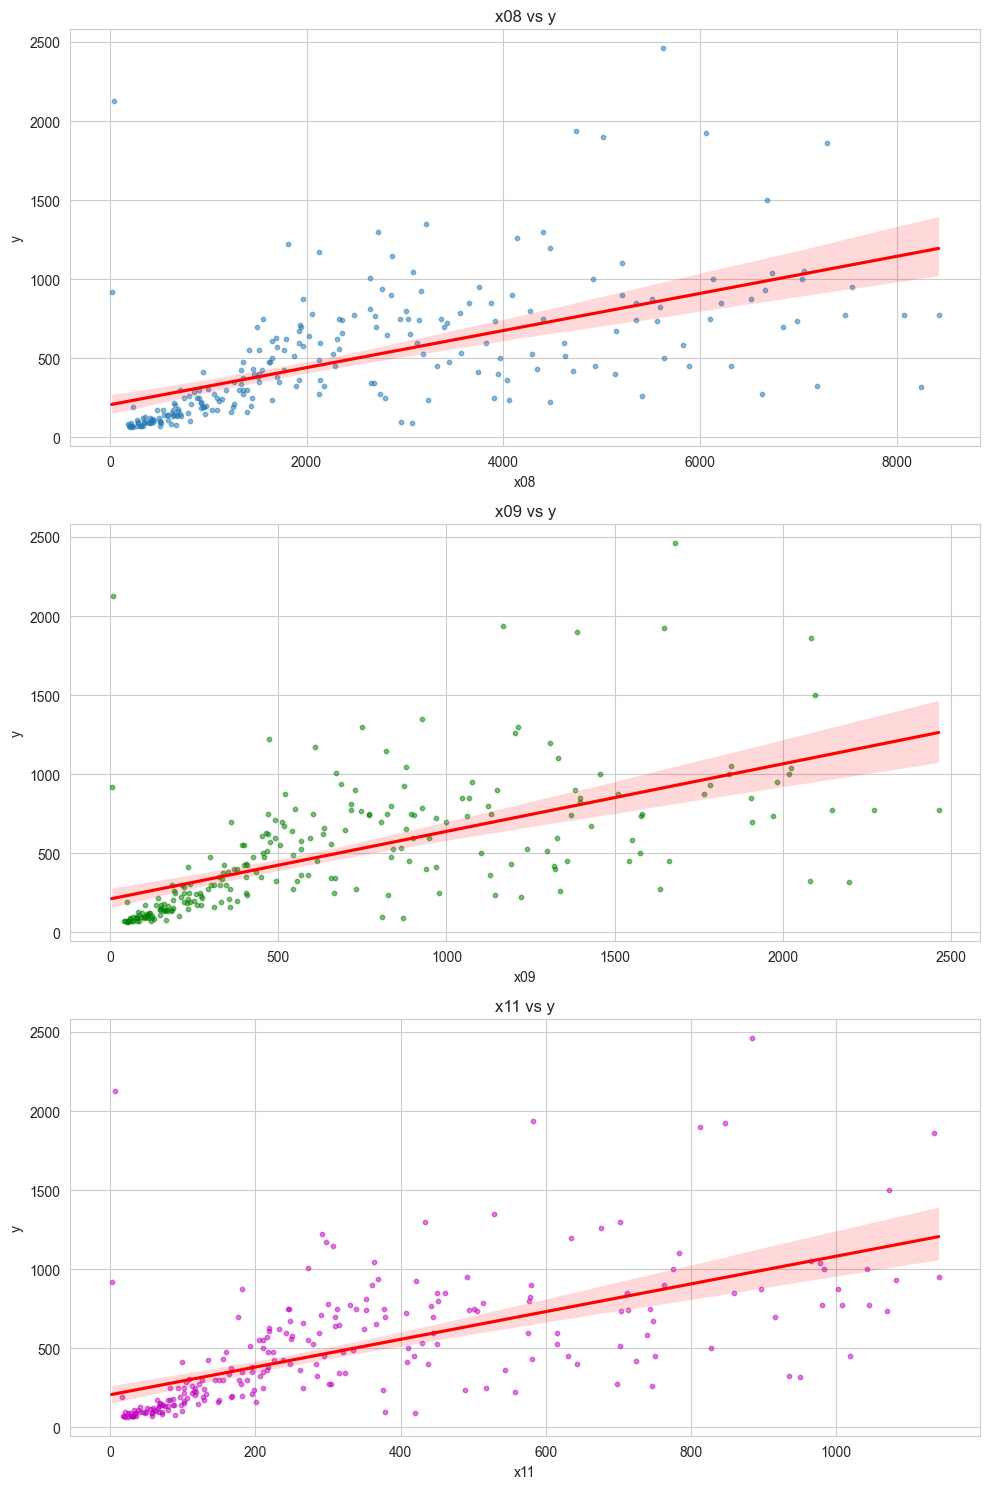

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
sns.regplot(x='x08', y='y', data=df, ax=ax[0], scatter_kws={'s':10, 'alpha':0.5}, line_kws={"color": "red"}).set(title='x08 vs y', xlabel='x08', ylabel='y')
sns.regplot(x='x09', y='y', data=df, ax=ax[1], color='g', scatter_kws={'s':10, 'alpha':0.5}, line_kws={"color": "red"}).set(title='x09 vs y', xlabel='x09', ylabel='y')
sns.regplot(x='x11', y='y', data=df, ax=ax[2], color='m', scatter_kws={'s':10, 'alpha':0.5}, line_kws={"color": "red"}).set(title='x11 vs y', xlabel='x11', ylabel='y')
plt.tight_layout()
plt.show()

Dapat dilihat, ketiga scatter plot ini memiliki pola yang mirip, yaitu semakin besar nilai variabel, semakin besar pula nilai `y`.

Ini berarti semakin besar nilai ketiga variabel, maka semakin besar pula nilai `y`.

##### Cara Kedua

Cara kedua adalah dengan melihat nilai korelasi antara variabel-variabel ini dengan `y`.

In [41]:
pearson_correlations = df[['x08', 'x09', 'x11', 'y']].corr()
pearson_correlations

,x08,x09,x11,y
x08,1.000000,0.995682,0.981735,0.592623
x09,0.995682,1.000000,0.984166,0.605339
x11,0.981735,0.984166,1.000000,0.626232
y,0.592623,0.605339,0.626232,1.000000


Dapat dilihat, variabel `x08`, `x09`, dan `x11` memiliki nilai korelasi positif dengan `y`, yaitu 0.59, 0.61, dan 0.63 secara berurutan.

Dari segi korelasi, justru `x11` lah yang paling berpengaruh terhadap `y`.



##### Kesimpulan
Dengan demikian, dapat disimpulkan bahwa ketiga variabel ini memiliki pengaruh yang signifikan terhadap nilai `y`.

Semakin besar nilai ketiga variabel ini, maka semakin besar pula nilai `y`.

Dari sisi bisnis, jika kita bertujuan untuk meningkatkan nilai `y`, maka kita dapat fokus pada faktor-faktor yang dapat meningkatkan nilai ketiga variabel ini.


#### API

Untuk memudahkan, saya akan menggunakan Flask untuk membuat API.

In [44]:
import pickle

from flask import Flask, jsonify, request

import numpy as np
import pandas as pd

In [49]:
with open('random_forest_model.pkl', 'rb') as file:
    rf_model = pickle.load(file)

app = Flask(__name__)

@app.errorhandler(e)
    def handle_error(e):
        return "Error: Input tidak lengkap atau tidak sesuai.", 500 

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)

    feature_names = ["x01", "x02", "x03", "x05", "x06", "x07", 
                     "x08", "x09", "x10", "x11", "x12", "x13"]

    features = pd.DataFrame([[data['x01'], data['x02'], data['x03'], data['x05'], data['x06'], data['x07'],
                             data['x08'], data['x09'], data['x10'], data['x11'], data['x12'], data['x13']]],
                             columns=feature_names)

    try:
        prediction = rf_model.predict(features)
        prediction = np.exp(prediction) - 1
        prediction = np.round(prediction * 2) / 2
        return jsonify({'prediction': prediction[0]})
    except KeyError as e:
        app.register_error_handler(500, handle_r(e))

app.run(host='0.0.0.0', port=80)


SyntaxError: invalid syntax (1986411492.py, line 23)

Sebagai contoh, saya akan menggunakan data pada tabel yang tidak memiliki nilai `y`. 

Walaupun model final hanya dilatih dengan 12 fitur, saya akan menggunakan seluruh fitur sebagai input untuk memudahkan.

``` json
{
    "x01": 293.0,
    "x02": 66.0,
    "x03": 1.0,
    "x04": 30.0,
    "x05": 29.0,
    "x06": 14.0,
    "x07": 1.0,
    "x08": 293.0,
    "x09": 66.0,
    "x10": 1.0,
    "x11": 30.0,
    "x12": 29.0,
    "x13": 14.0,
    "x14": 446.0,
    "x15": 33.0,
    "x16": 20.0
}
```

Jika dijalankan, maka akan muncul hasil prediksi dari model yang telah dibuat.

``` json
{
  "prediction": 83.0
}
```